# Домашнее задание к лекции "Визуализация данных"

## Обязательная часть

Вам необходимо провести базовый [EDA](https://en.wikipedia.org/wiki/Exploratory_data_analysis) выбранного набора данных. 

Требования к анализу:
- построить не менее 4 визуализаций различных видов;
- каждая визуализация должным образом оформлена и читается даже в отрыве от контекста; 
- по каждой визуализации необходимо написать вывод (какую гипотезу на ее основе можно выдвинуть?).

**Откуда брать данные?**

Можете взять свои рабочие данные, либо найти открытые данные (например, на [kaggle.com](https://www.kaggle.com/)) по интересующей вас предметной области (тогда не забудьте их выложить на github вместе с ноутбуком). Если идей нет, можете взять один из перечисленных ниже:
- [данные приложений из Google Play](https://www.kaggle.com/lava18/google-play-store-apps);
- [данные о видео из трендов YouTube](https://www.kaggle.com/datasnaek/youtube-new);
- [данные об уровне счастья в разных странах](https://www.kaggle.com/unsdsn/world-happiness);
- [данные по фильмам и сериалам Netflix](https://www.kaggle.com/shivamb/netflix-shows).

### Дополнительная часть (необязательная)

* построить дополнительно не менее 2 визуализаций (итого не менее 6);
* в работе должны присутствовать следующие визуализации: boxplot, heatmap, scatter plot matrix;
* не менее двух визуализаций должны быть интерактивными.

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import re
from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go
from pylab import rcParams

init_notebook_mode(connected=True)
rcParams['figure.figsize'] = 10,7

In [135]:
def fix_reviews(col):
    if isinstance(col, str):
        if "M" in col:
            return int(float(col.replace("M", "")) * 1000000)
        else:
            return int(col)
    else:
        return col
    
def fix_installs(col):
    if isinstance(col, str):
        val = re.sub("[,+]", "", col)
        if val == "" or val == "Free":
            return 0
        else:
            return int(val)
    else:
        return col
    
def fix_prices(col):
    if isinstance(col, str) and "$" in col:
        return float(col.replace("$", ""))
    else:
        return float(col)

def fix_ratings(col):
    if np.isnan(col):
        return col
    else:
        return round(int(col * 10)) / 10

def fix_values(row):
    row["Reviews"] = fix_reviews(row["Reviews"])
    row["Installs"] = fix_installs(row["Installs"])
    row["Price"] = fix_prices(row["Price"])
    return row

def get_column_groupby_rules(df):
    rules = {}
    for column in df.columns:
        if column in ["Rating", "Price"]:
            rules[column] = "mean"
        elif column in ["Reviews", "Installs"]:
            rules[column] = "sum"
        elif column != "App":
            rules[column] = "last"
    return rules

# загружаем данные
store = pd.read_csv("googleplaystore.csv")
reviews = pd.read_csv("googleplaystore_user_reviews.csv")

# готовим данные
store = (store
             .drop(store.loc[store["Rating"] > 5.0].index)                       # удаляем некорректные данные
             .apply(fix_values, axis=1).sort_values(["App", "Current Ver"])      # готовим к группировке
             .groupby("App").agg(get_column_groupby_rules(store)).reset_index()) # группируем по приложениям
store["Rating"] = store["Rating"].apply(fix_ratings)                             # округляем до 1 знака

print("Приложения")
display(HTML(store.head().to_html()))
print("Отзывы")
display(HTML(reviews.head().to_html()))

Приложения


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,"""i DT"" Fútbol. Todos Somos Técnicos.",SPORTS,NaN,27,3.6M,500,Free,0.0,Everyone,Sports,"October 7, 2017",0.22,4.1 and up
1,+Download 4 Instagram Twitter,SOCIAL,4.5,40467,22M,1000000,Free,0.0,Everyone,Social,"August 2, 2018",5.03,4.1 and up
2,- Free Comics - Comic Apps,COMICS,3.5,115,9.1M,10000,Free,0.0,Mature 17+,Comics,"July 13, 2018",5.0.12,5.0 and up
3,.R,TOOLS,4.5,259,203k,10000,Free,0.0,Everyone,Tools,"September 16, 2014",1.1.06,1.5 and up
4,/u/app,COMMUNICATION,4.7,573,53M,10000,Free,0.0,Mature 17+,Communication,"July 3, 2018",4.2.4,4.1 and up


Отзывы


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,"I like eat delicious food. That's I'm cooking food myself, case ""10 Best Foods"" helps lot, also ""Best Before (Shelf Life)""",Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


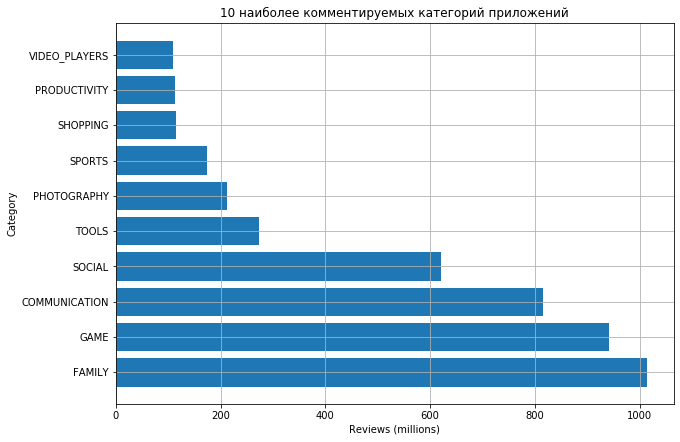

In [136]:
st = pd.DataFrame(store[["Category", "Reviews"]].groupby("Category").sum().reset_index()
                  .sort_values("Reviews", ascending=False).head(10))
st["Reviews"] = st["Reviews"] // 1000000

plt.barh(st["Category"], st["Reviews"])
plt.xlabel("Reviews (millions)")
plt.ylabel("Category")
plt.title("10 наиболее комментируемых категорий приложений")
plt.grid()

Наибольшее число отзывов для приложений из индустрии развлечений, коммуникаций и сопрта. Также в топ попали программы-помощники (tools). Очевидно, что эти приложения самые востребованные и требований к ним больше, а, значит, и отзывов. Однако, весьма странно, что образовательные программы не попали в этот рейтинг. Видимо, они пользуются меньшим спросом, либо пользователи не считают нужным оставлять по ним комментарии.

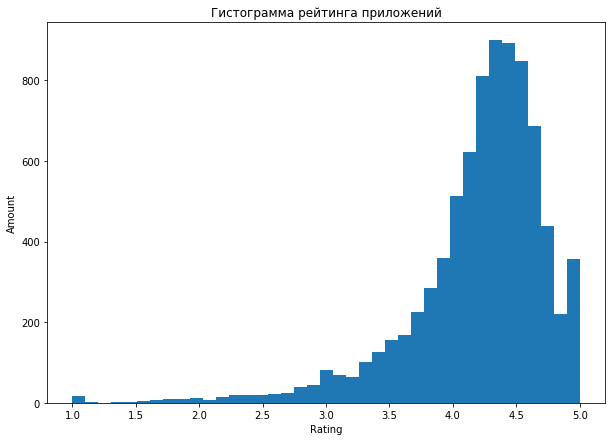

In [137]:
store["Rating"].hist(bins=len(store["Rating"].value_counts()))

plt.title("Гистограмма рейтинга приложений")
plt.xlabel("Rating")
plt.ylabel("Amount")
plt.grid()

В целом, рейтинг приложений высокий. Больше всего приложений с рейтингом 4.3-4.6. Имеется некоторая аномалия в виде локальных пиков на 1.0, 3.0 и 5.0. Вероятнее всего это связано с малым количеством оценок.

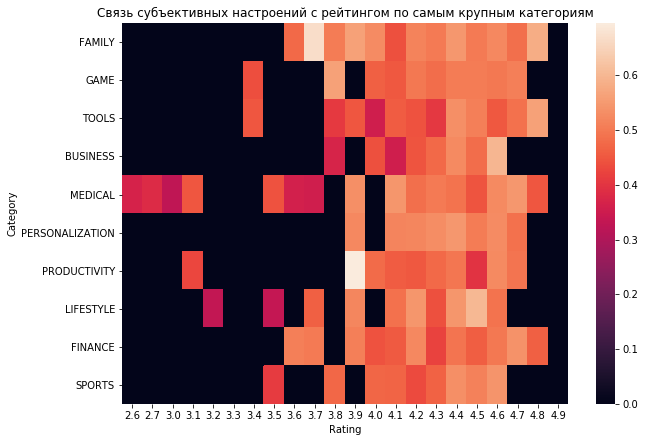

In [138]:
top_biggest = store["Category"].value_counts().sort_values(ascending=False).head(10).index.values
reviews_gr = reviews[["App", "Sentiment_Subjectivity"]].groupby("App").mean().reset_index()
merged = store.merge(reviews_gr, how="left").dropna()
pt = merged.pivot_table(index="Category", columns="Rating", values="Sentiment_Subjectivity").fillna(0)
pt = pt.reindex(top_biggest)

plt.title("Связь cубъективных настроений с рейтингом по самым крупным категориям")
sns.heatmap(pt);

Заметно, что вне зависимости от категорий наилучшие субъективные настроения проявляются при рейтинге в диапозоне 4.1-4.6. Выделяются категории медицинских приложений и образа жизни по хорошим настроениям в более широком спектре рейтинга.

Взаимосвязь кол-ва отзывов (млн), установок приложений (млн) и субъективности настроений


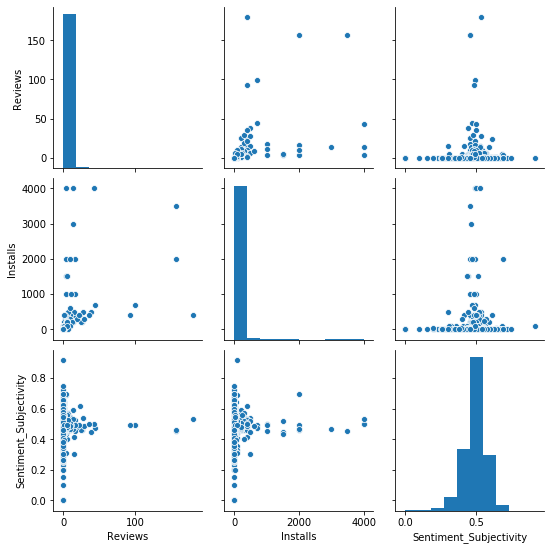

In [139]:
inf = pd.DataFrame(merged[["Reviews", "Installs", "Sentiment_Subjectivity"]])
inf["Reviews"] = inf["Reviews"].apply(lambda x: x / 1000000)
inf["Installs"] = inf["Installs"].apply(lambda x: x / 1000000)

sns.pairplot(inf)
print("Взаимосвязь кол-ва отзывов (млн), установок приложений (млн) и субъективности настроений");

По представленным графикам можно сказать, что кол-во отзывов слабо зависит от кол-ва установок приложений. Некоторое соотвествие есть лишь примерно до 800 млн. установок. Больший разброс настроений оценок прослеживается при сравнительно небольшом кол-ве отзывов и установок приложений.

In [140]:
top_biggest = store["Category"].value_counts().sort_values(ascending=False).head(10).index.values
data_box = []
for category in top_biggest:
    data_box.append(go.Box(y=store[store["Category"] == category]["Rating"], name=category))

layout_box = {"title": "Размах распределения ретинга по самым крупным категориям"}
fig_box = go.Figure(data=data_box, layout=layout_box)
iplot(fig_box)

Наибольший размах оценок в категории LIFESTILE. Наименьший - в GAME. Можно предположить, что пользователи приложений из катерии LIFESTILE более требовательны к приложениям. Среднее же значение рейтинга по всем самым широким категориям примерно одинаковое.

In [141]:
by_category = (store[store["Category"].isin(top_biggest)]
                .set_index("Category").loc[top_biggest].reset_index()
                .groupby("Category").agg({"Installs": "sum", "Reviews": "sum", "App": "count"})
                .sort_values("App", ascending=False))
by_category["Activity"] = by_category.apply(lambda row: row["Installs"] / row["Reviews"], axis=1)

data_act = go.Bar(x=by_category.index, y=by_category["Activity"], orientation = "v")
layout_act = {"title": "Пользовательская активность (отношение установок к отзывам) по самым крупным категориям"}
fig_act = go.Figure(data=data_act, layout=layout_act)
iplot(fig_act)

Наибольшая пользовательская активность для самых крупных категорий видна в категории PRODUCTIVITY. Это выглядит несколько странно, поскольку для действительно продуктивных тратить свое время на комментирование весьма нелогично. В противоположность этому пользователи приложений из категории SPORTS показали наименьшую активность. В этом случае все вполне логично: люди, увлекающиеся спортом ценят свое время.

#### ПРИМЕЧАНИЕ
Домашнее задание сдается ссылкой на репозиторий [GitHub](https://github.com/).
Не сможем проверить или помочь, если вы пришлете:
- файлы;
- архивы;
- скриншоты кода.

Все обсуждения и консультации по выполнению домашнего задания ведутся только на соответствующем канале в slack.

##### Как правильно задавать вопросы аспирантам, преподавателям и коллегам
Прежде чем задать вопрос, попробуйте найти ответ в интернете. Навык самостоятельного поиска информации — один из важнейших. Каждый практикующий специалист любого уровня делает это ежедневно.

Сформулируйте вопрос по алгоритму:  
1) Что я делаю?  
2) Какого результата я ожидаю?  
3) Как фактический результат отличается от ожидаемого?  
4) Что я уже попробовал сделать, чтобы исправить проблему?  

По возможности прикрепите к вопросу скриншоты либо ссылки на код. Не выкладывайте все решение, оставляйте только проблемный и воспроизводимый участок кода.